## Assignment 2

### Imports and inits

In [1]:
import datetime                                               # for timestamp 
import h2o                                                    # base h2o package for python
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch                # grid search class and syntax for h2o models
from interpret import show                                    # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting  
import time                                                   # for timers
import xgboost as xgb                                             # base h2o package for python
import shap                                                      #get sharply values
import warnings                                                # remove warnings

# Disable the warning about inplace assignment
warnings.filterwarnings("ignore", message=".*'SettingWithCopyWarning: .*")

# Disable the warning about the deprecated frame.append method
warnings.filterwarnings("ignore", message=".*'frame.append' is deprecated.*")

warnings.filterwarnings("default", message=".*'SettingWithCopyWarning: .*")
warnings.filterwarnings("default", message=".*'frame.append' is deprecated.*")
# set numpy random seed for better reproducibility
SEED = 12345 
import warnings
warnings.filterwarnings('ignore')

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators    

/Users/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,45 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 22 days
H2O_cluster_name:,H2O_from_python_joonkyuhong_hnz62d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


###  Start global timer

In [2]:
tic = time.time()

### Import data

In [3]:
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

### Assign basic modeling roles

In [4]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

## Fit interpretable models

### Split data into train and validation partitions

In [5]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


## Lasso

### Define wrapper function for grid search

In [6]:
def glm_grid(x_names, y_name, htrain, hvalid, seed):
    """Wrapper function for penalized GLM with alpha and lambda search.

    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param htrain: Training H2OFrame.
    :param hvalid: Validation H2OFrame.
    :param seed: Random seed for better reproducibility.
    :return: Best H2OGeneralizedLinearEstimator.
    """

    alpha_opts = [1.0]  # Use 1.0 for Lasso (full L1 regularization)

    # Define search criteria
    # i.e., over alpha
    # lambda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts}

    # Initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family='binomial',
                                      lambda_search=True,
                                      seed=seed),  # seed for grid search
        hyper_params=hyper_parameters)

    # Execute training w/ grid search
    grid.train(y=y_name,
               x=x_names,
               training_frame=htrain,
               validation_frame=hvalid,
               seed=seed)  # seed for training

    # Select best model from grid search
    best_model = grid.get_grid()[0]
    del grid

    return best_model

### Fit Lasso with grid search

In [7]:
# start local timer
glm_tic = time.time()

# convert data to h2o frames
htrain = h2o.H2OFrame(train)
hvalid = h2o.H2OFrame(valid)

# train with grid search
best_glm = glm_grid(x_names, y_name, htrain, hvalid, SEED)

# end local timer
glm_toc = time.time() - glm_tic
print('Lasso GLM training completed in %.2f s.' % (glm_toc))

Lasso GLM training completed in 6.38 s.


### Basic AUC assessment

In [8]:
print('Validation AUC: %.4f.' % best_glm.auc(valid=True))

Validation AUC: 0.7534.


### Score validation data with model

In [9]:
best_glm_phat = best_glm.predict(hvalid).as_data_frame() 
best_glm_phat.drop(['predict', 'p0'], axis=1, inplace=True)
best_glm_phat.columns = ['phat']
best_glm_phat = pd.concat([valid.reset_index(drop=True), best_glm_phat], axis=1)
best_glm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.155701
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.157247
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.076999
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.125665
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.050964


### Utility function for selecting percentiles

In [10]:
def get_percentile_dict(yhat_name, frame, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
        :param yhat_name: Name of column in frame in which to find percentiles.
        :param frame: Pandas frame.
        :param id_: Validation Pandas frame containing yhat and id_.
        :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict

### Select percentiles from predictions

In [11]:
best_glm_percentiles = get_percentile_dict('phat', best_glm_phat, 'row_id')
for key in sorted(best_glm_percentiles.keys()):
    print(str(key) + ': ' + str(best_glm_percentiles[key]))

0: 152878
10: 68824
20: 44085
30: 62931
40: 158849
50: 113207
60: 122249
70: 58799
80: 97248
90: 34453
99: 46601


### Collect global feature importance info

In [12]:
# use coefficients as relative global feature importance
global_fi = pd.DataFrame.from_dict(best_glm.coef(), columns=['GLM Importance'], orient='index')
global_fi.drop('Intercept', inplace=True)
global_fi['GLM Importance'] = np.abs(global_fi['GLM Importance'])

### Collect local feature importance info

In [13]:
# use (coefficient * value) as local feature importance

# init frame to store local contribs
local_fi_dict = {10: pd.DataFrame(columns = ['GLM Contribution'], index=x_names),
                 50: pd.DataFrame(columns = ['GLM Contribution'], index=x_names),
                 90: pd.DataFrame(columns = ['GLM Contribution'], index=x_names)}

# get (coefficient * value) at three percentiles of phat
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # local contributions = beta_j * x_i,j
        local_fi_dict[percentile].loc[name, 'GLM Contribution'] =\
            best_glm.coef()[name] *\
            valid[valid['row_id'] == int(best_glm_percentiles[percentile])][name].values[0]

## Regular XGBoost

### Define utility function for random grid search

In [14]:
def xgb_grid(dtrain, dvalid, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(seed) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective, etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': -1,
              'objective': 'binary:logistic',
              'seed': seed}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        candidate = xgb.train(params,
                              dtrain,
                              num_boost_round=ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
            
    return best_candidate

### Fit Regular XGBoost with random grid search

In [15]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7],
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}

# start local timer
xgb_tic = time.time()

# Convert data to DMatrix format
dtrain = xgb.DMatrix(train[x_names], train[y_name])
dvalid = xgb.DMatrix(valid[x_names], valid[y_name])

# Regular XGBoost grid search
best_xgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=50, ntree=1000, early_stopping_rounds=100, seed=SEED)

# end local timer
xgb_toc = time.time() - xgb_tic
print('XGBoost training completed in %.2f s.' % (xgb_toc))


Grid search run 1/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': -1, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0}
Grid search new best score discovered at iteration 1/50: 0.8209.
---------- ----------
Grid search run 2/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': -1, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.2}
Grid search new best score discovered at iteration 2/50: 0.8252.
---------- ----------
Grid search run 3/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': -1, 'objective': 'binary:logistic', 'seed': 12345, 'colsample

---------- ----------
Grid search run 24/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': -1, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.0}
Grid search new best score discovered at iteration 24/50: 0.8270.
---------- ----------
Grid search run 25/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': -1, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.0}
---------- ----------
Grid search run 26/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': -1, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9,

---------- ----------
Grid search run 47/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': -1, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.2}
---------- ----------
Grid search run 48/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': -1, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.2}
---------- ----------
Grid search run 49/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': -1, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0

### Basic AUC assessment

In [16]:
print('Validation AUC: %.4f.' % best_xgb.best_score)

Validation AUC: 0.8270.


### Score validation data with model

In [17]:
best_xgb_phat = pd.DataFrame(best_xgb.predict(dvalid, iteration_range=(0, best_xgb.best_ntree_limit)), columns=['phat']) 
best_xgb_phat = pd.concat([valid.reset_index(drop=True), best_xgb_phat], axis=1)
best_xgb_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.183958
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.307281
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.021336
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.011120
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.005775


### Select percentiles from predictions

In [18]:
best_xgb_percentiles = get_percentile_dict('phat', best_xgb_phat, 'row_id')
for key in sorted(best_xgb_percentiles.keys()):
    print(str(key) + ': ' + str(best_xgb_percentiles[key]))

0: 33034
10: 42390
20: 44094
30: 30455
40: 103139
50: 137992
60: 67944
70: 116217
80: 61926
90: 57043
99: 106227


### Calculate Shapley values & Collect global feature importance info

In [19]:
# Convert the XGBoost model to a tree explainer
explainer = shap.TreeExplainer(best_xgb)

# Calculate the SHAP values for the validation dataset
shap_values = explainer.shap_values(dvalid)

# Compute the mean absolute SHAP values
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Add the mean absolute SHAP values to the global feature importance DataFrame
global_fi['XGBoost Importance'] = mean_abs_shap[0]

### Collect local feature importance info

In [20]:
# Create mapping between validation row_id and SHAP array index values
valid_idx_map = valid['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True)

# Collect SHAP values at three percentiles of phat
for percentile in [10, 50, 90]:
    # Find the index of the corresponding row in the valid_idx_map
    idx = valid_idx_map[valid_idx_map == int(best_xgb_percentiles[percentile])].index[0]

    # Create a DataFrame with the SHAP values for the selected index
    s_df = pd.DataFrame(shap_values[idx], columns=['XGBoost Contribution'], index=x_names)

    # Update the local feature importance dictionary with the SHAP values
    local_fi_dict[percentile]['XGBoost Contribution'] = 0
    local_fi_dict[percentile].update(s_df)

## Explainable Boosting Machine

### Define utility function for random grid search

In [21]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name]) 
        
        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del ebm
            
    return best_candidate

### Fit EBM with random grid search`

In [22]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm = ebm_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=10, 
                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/10: 0.8218.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max

### Basic AUC assessment

In [23]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8253.


### Score validation data with model

In [24]:
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:, 1], columns=['phat']) 
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.165646
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.314594
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.022284
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.015600
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.004888


### Select percentiles from predictions

In [25]:
best_ebm_percentiles = get_percentile_dict('phat', best_ebm_phat, 'row_id')
for key in sorted(best_ebm_percentiles.keys()):
    print(str(key) + ': ' + str(best_ebm_percentiles[key]))

0: 64814
10: 92353
20: 127541
30: 91459
40: 65446
50: 67026
60: 97927
70: 40567
80: 61761
90: 98008
99: 105145


In [29]:
#start local timer
ebm_tic = time.time()

# use EBM feature scores as local importance
# use mean abs score as global importance
best_ebm_contribs = best_ebm.explain_local(valid[x_names])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
# new versions just have predict_and_explain() function
# use that if you can
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, 25), columns=names)
    best_ebm_contribs_df = best_ebm_contribs_df.append(row_df, ignore_index=True)
    del row_df
    
# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))

EBM contributions collected in 20.42 s.


### Collect global feature importance info

In [30]:
global_fi['EBM Importance'] = np.abs(best_ebm_contribs_df).mean()

### Collect local feature importance info

In [31]:
# extract scores at three percentiles of phat
for percentile in [10, 50, 90]:
 
    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_ebm_percentiles[percentile])].index[0]
    s_df = best_ebm_contribs_df.iloc[idx, :len(x_names)].T
    s_df.columns = ['EBM Contribution']
    local_fi_dict[percentile]['EBM Contribution'] = s_df

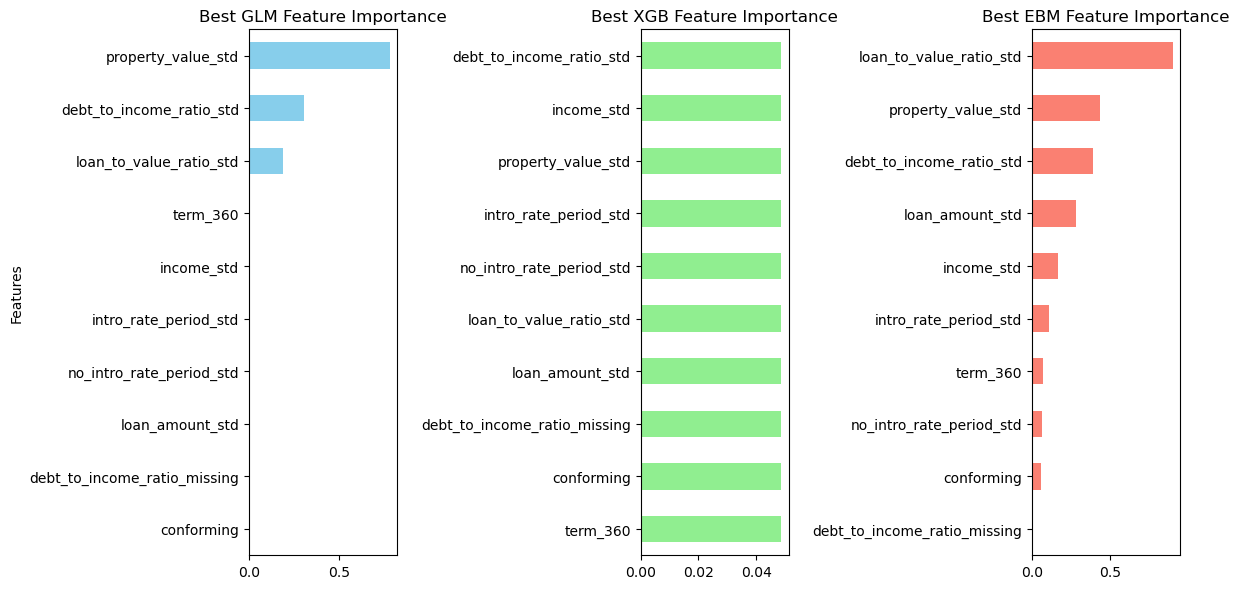

In [32]:
# Create a figure with subplots
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 6))

# Set the titles for the subplots
ax0.set_title('Best GLM Feature Importance')
ax1.set_title('Best XGB Feature Importance')
ax2.set_title('Best EBM Feature Importance')

# Plot the feature importance for GLM
global_fi['GLM Importance'].sort_values().plot(kind='barh', ax=ax0, color='skyblue')

# Plot the feature importance for MXGB
global_fi['XGBoost Importance'].sort_values().plot(kind='barh', ax=ax1, color='lightgreen')

# Plot the feature importance for EBM
global_fi['EBM Importance'].sort_values().plot(kind='barh', ax=ax2, color='salmon')

# Set the y-axis label for the subplots
ax0.set_ylabel('Features')
ax1.set_ylabel('')
ax2.set_ylabel('')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

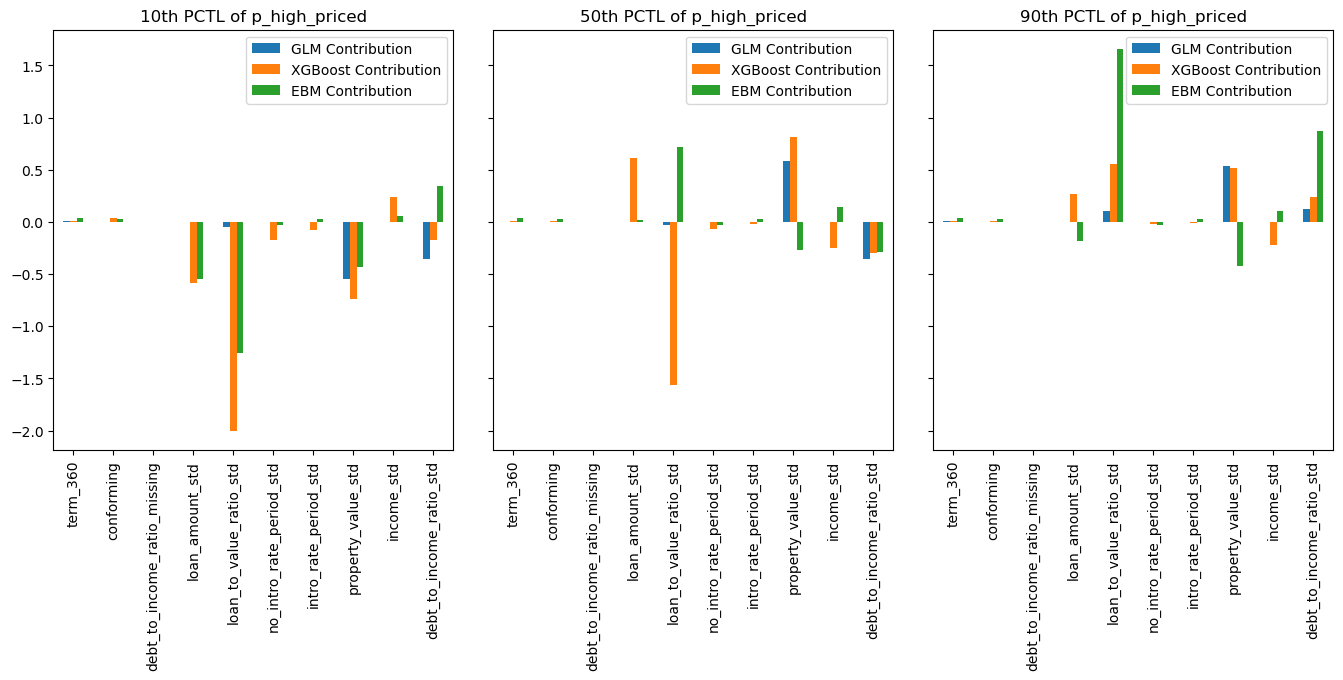

In [33]:
## init 3-pane plot 
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# plot comparisons of local FI across 3 panes
_ = local_fi_dict[10].plot(kind='bar', ax=ax0,
                             title='10th PCTL of p_high_priced')

_ = local_fi_dict[50].plot(kind='bar', ax=ax1,
                             title='50th PCTL of p_high_priced')

_ = local_fi_dict[90].plot(kind='bar', ax=ax2,
                             title='90th PCTL of p_high_priced')



In [34]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'h2o':
        temp_df['partial_dependence'] = model.predict(h2o.H2OFrame(temp_df))['p1'].as_data_frame()
    if model_type == 'xgb':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict(xgb.DMatrix(temp_df), iteration_range=(0, best_xgb.best_ntree_limit)), columns=['phat'])
    if model_type == 'ebm':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict_proba(temp_df)[:, 1], columns=['phat'])
    
    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

In [35]:
# Suppress the warning about df.iloc[:, i] assignment
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.core.indexing")

# Suppress the warning about frame.append deprecation
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.core.frame")
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_names:
    
    print('Calculating partial dependence for %s ...' % name)
    
    # setup a dataframe to hold results
    # use bins from first par_dep() run
    pd_dict[name] = pd.DataFrame(columns=[name, 'h2o', 'xgb', 'ebm'])
    first_pd = par_dep(name, valid[x_names], best_glm, 'h2o')
    pd_dict[name][name] = first_pd[name]
    bins = first_pd[name]
    pd_dict[name]['h2o'] = first_pd['partial_dependence']
    
    # calculate par dep for remaining models
    pd_dict[name]['xgb'] = par_dep(name, valid[x_names], best_xgb, 'xgb', bins=bins)['partial_dependence']
    pd_dict[name]['ebm'] = par_dep(name, valid[x_names], best_ebm, 'ebm', bins=bins)['partial_dependence']
    
print('Done.')

# end local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % (pd_toc))


Calculating partial dependence for term_360 ...
Calculating partial dependence for conforming ...
Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for income_std ...
Calculating partial dependence for debt_to_income_ratio_std ...
Done.
Partial dependence calculated in 84.46 s.


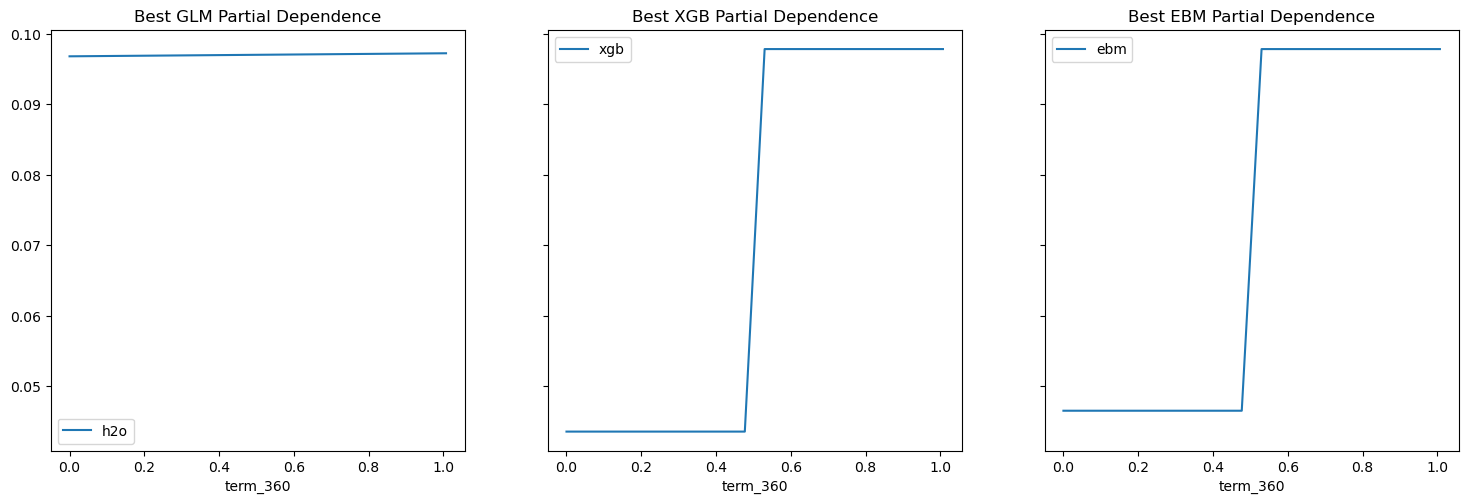

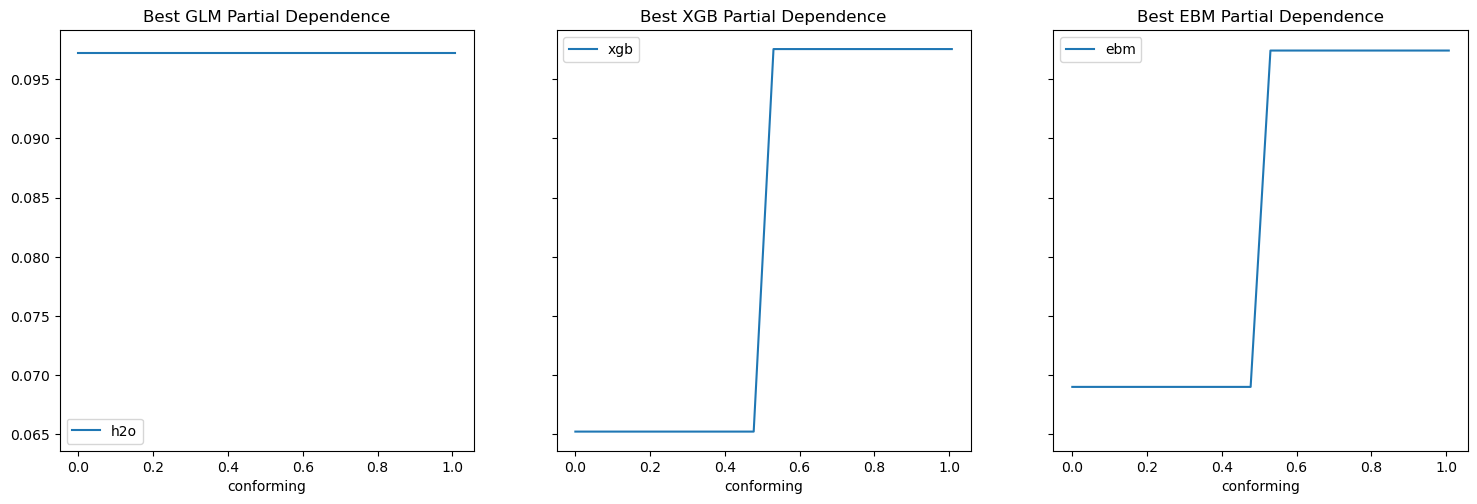

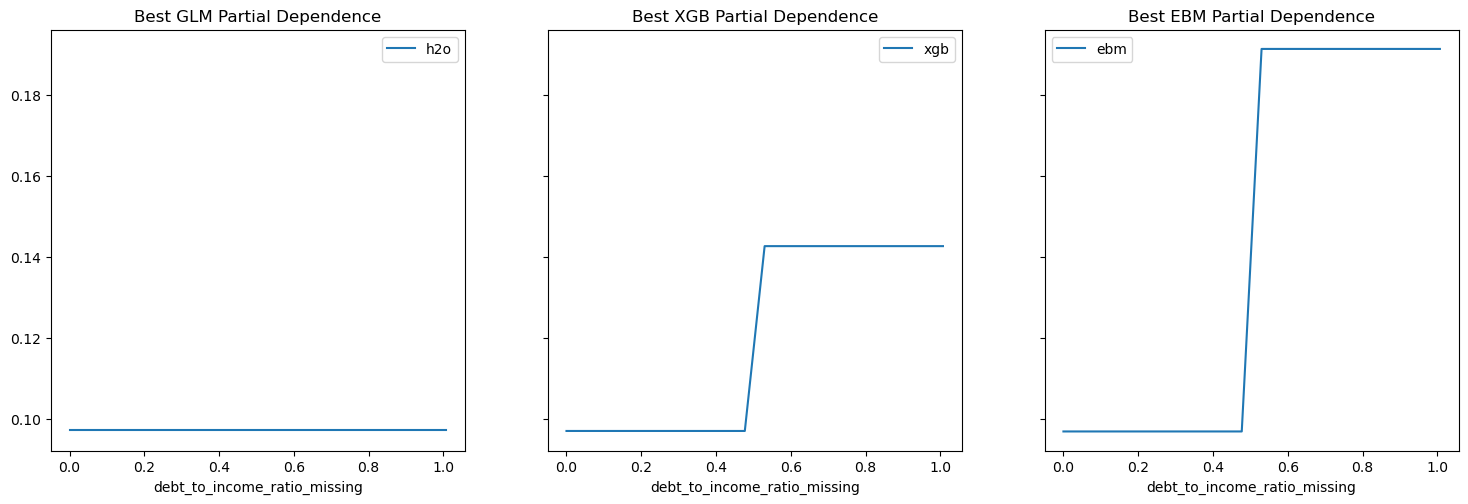

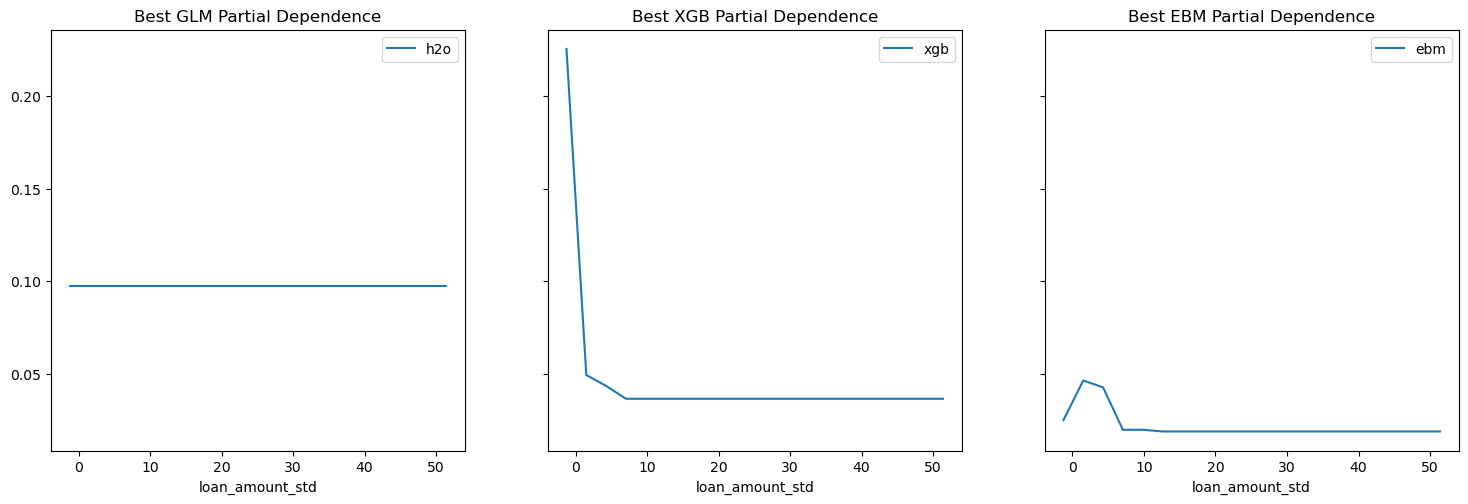

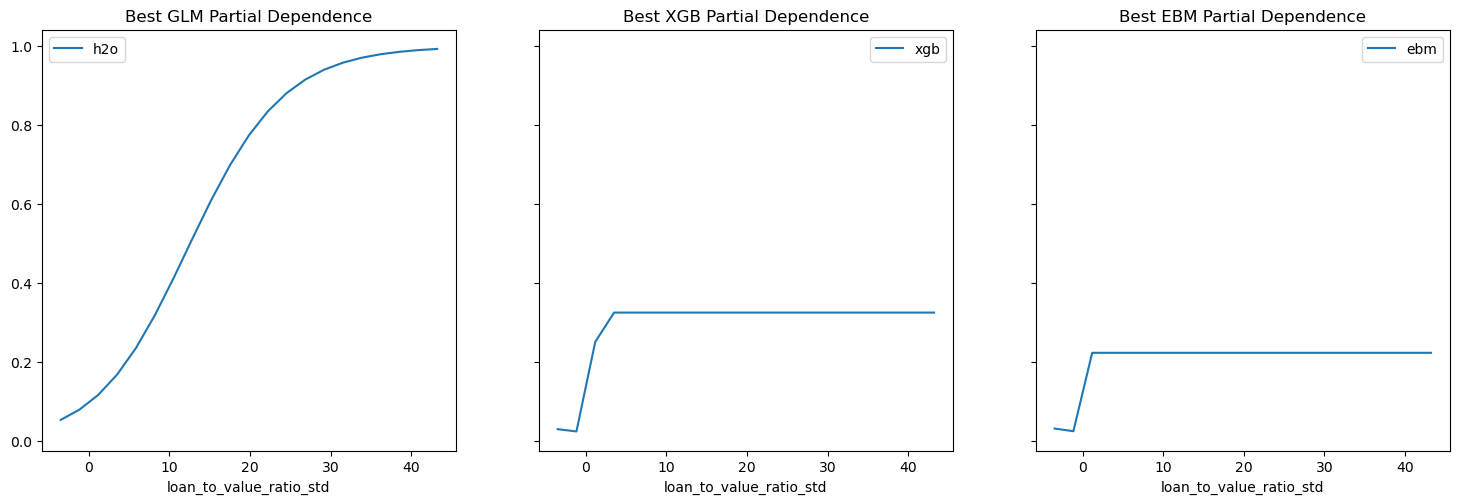

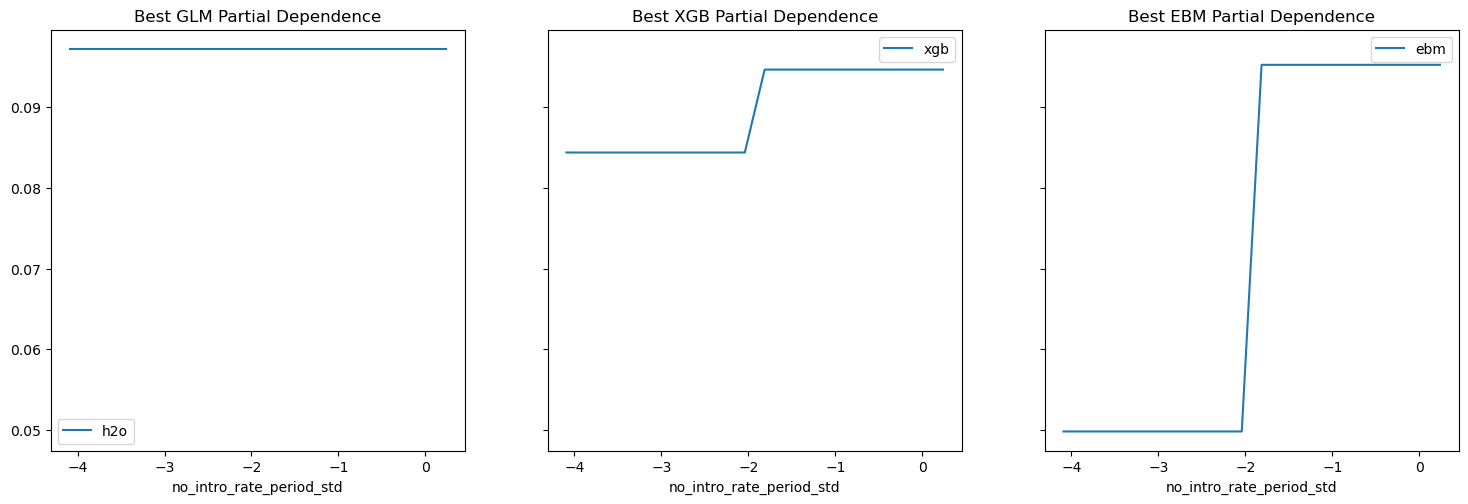

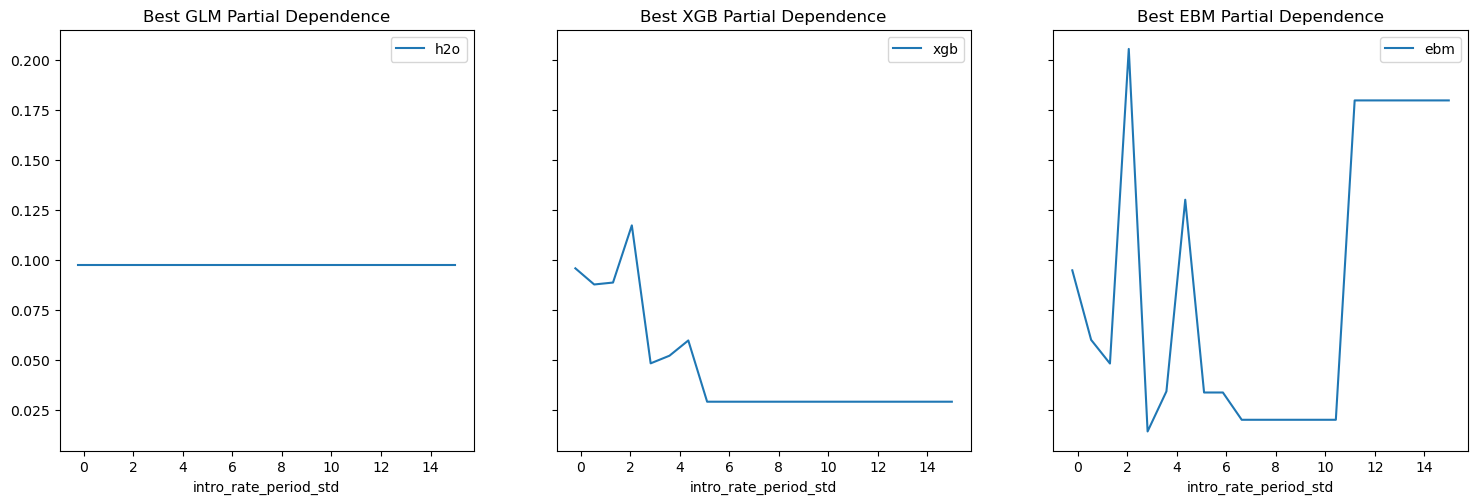

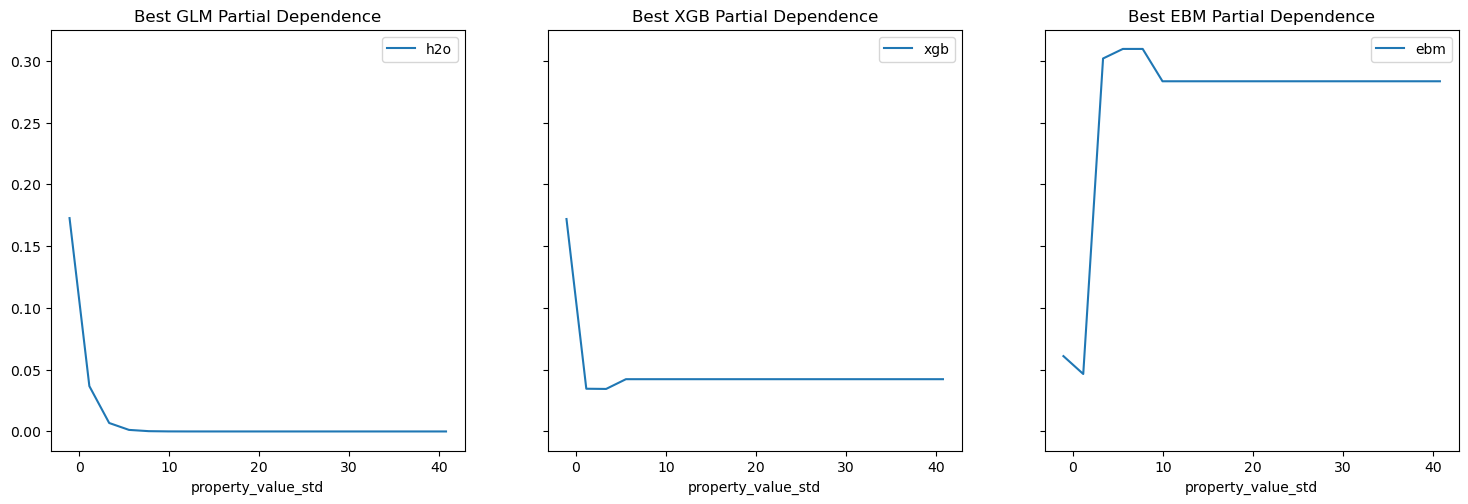

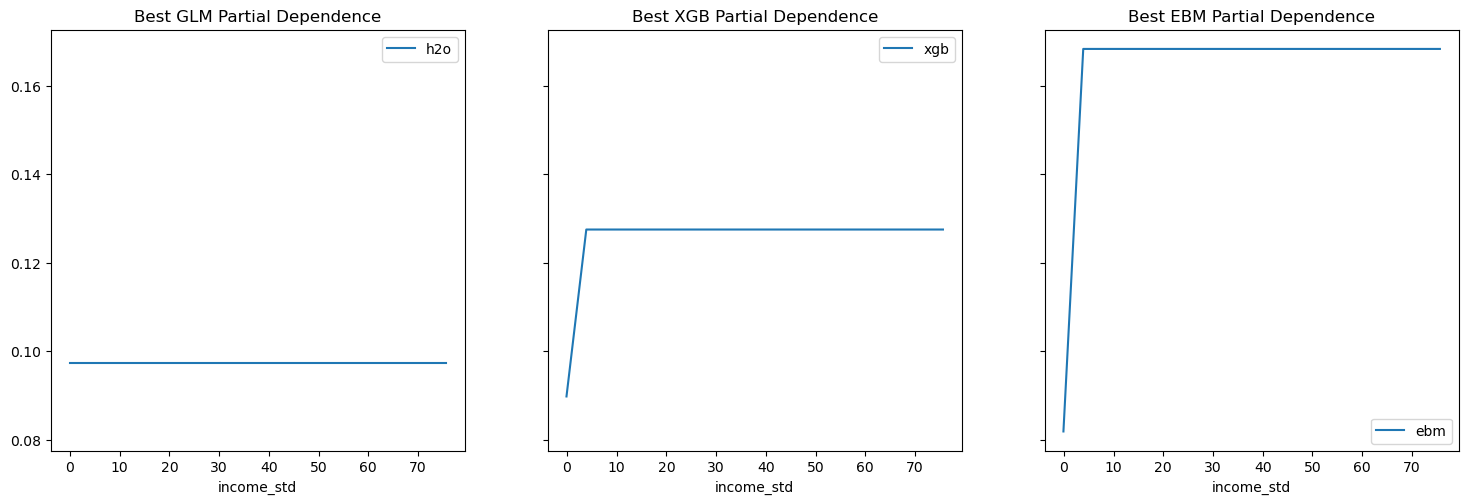

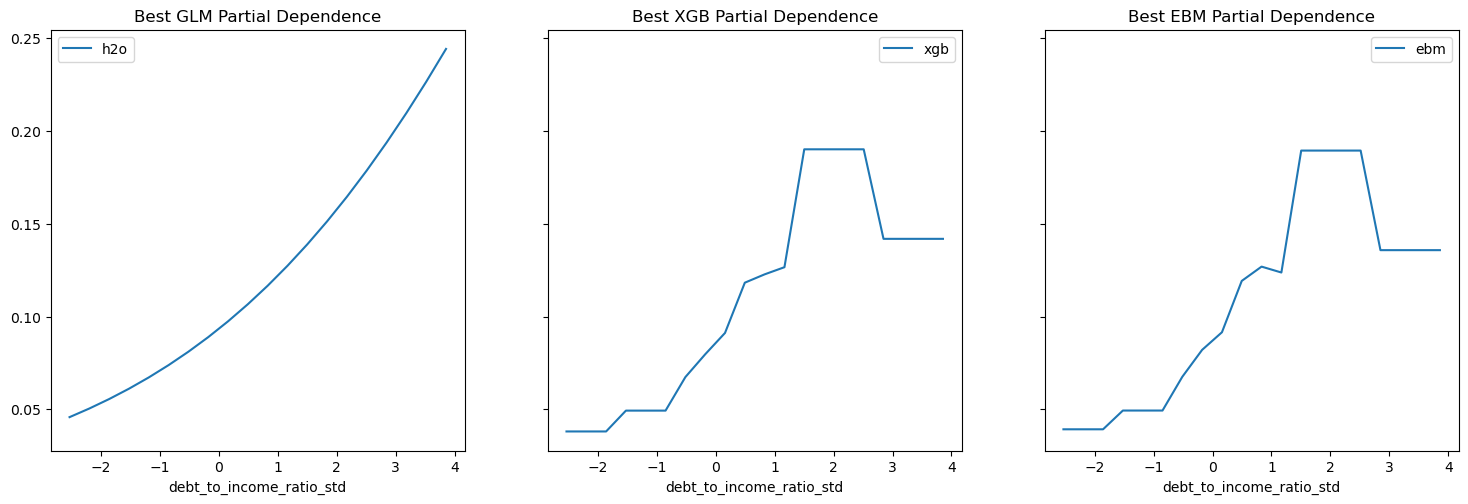

In [36]:
# loop through names to calculate par dep 
for name in x_names:
    
    # init 3-pane plot
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2)
  
    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='h2o', ax=ax0, title='Best GLM Partial Dependence')
    ax0.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='xgb', ax=ax1, title='Best XGB Partial Dependence') 
    ax1.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='ebm', ax=ax2, title='Best EBM Partial Dependence')
    ax2.set_xlabel(name)

### End timer

In [37]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 1662.04 s.


### Shutdown h2o

In [38]:
h2o.cluster().shutdown(prompt=False)

H2O session _sid_bc72 closed.
